This notebook scrapped about 5000 posts from Edmunds.com's [Midsized Sedans forum](https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans) and analyzed brand-to-brand competition. Topics of analysis include

- Brand-to-brand lift ratios (i.e., which brands are being compared with each other the most?)
- Brand-to-attribute lift ratios (i.e., which attributes is each brand known for?)
- Rankings of "inspirational" brands

## Data scraping
**Note:** The scraping section is intended to run on Google Colab. The actual analysis can be run on both Colab and local Jupyter Notebook.

### Selenium setup for data scraping

In [0]:
!pip install selenium
# !apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 911kB 2.8MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 28 not upgraded.
Need to get 70.8 MB of archives.
After this operation, 254 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 77.0.3865.90-0ubuntu0.18.04.1 [1,079 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 77.0.3865.90-0ubuntu0.18.04.1 [62.3 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe

In [2]:
import pandas as pd
driver = webdriver.Chrome('chromedriver', options=chrome_options)

### Test scrape
#### Source: https://towardsdatascience.com/web-scraping-using-selenium-python-8a60f4cf40ab

In [0]:
# test - userid
driver.get('https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p400')
# 540 pages total as of 11/1; to get more recent comments, start with Pg. 400

userid_element = driver.find_elements_by_xpath('//*[@id="Comment_4111987"]/div/div[2]/div[1]/span[1]/a[2]')[0]
userid = userid_element.text
print(userid)

ahightower


In [0]:
# test - date
user_date = driver.find_elements_by_xpath('//*[@id="Comment_4111987"]/div/div[2]/div[2]/span/a/time')[0]
date = user_date.get_attribute('title')
print(date)

January 9, 2014 5:14PM


In [0]:
# test - comment
user_message = driver.find_elements_by_xpath('//*[@id="Comment_4111987"]/div/div[3]/div/div[1]/p')[0]
comment = user_message.text
print(comment)

I count that in the Accord's favor...


In [0]:
# test - get all IDs from one page
ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
comment_ids = []
for i in ids:
    comment_ids.append(i.get_attribute('id'))
print(len(comment_ids)) #50 messages a page; need to get a 100 pages

50


### Scrape 5000 messages

In [0]:
import time
comments = {"Date": [], "Userid": [], "Message": []}
pages = range(1,101)
for page in pages:
    webpage = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p' + str(400 + page)
    driver.get(webpage)
    comment_ids = []
    ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
    for i in ids:
        comment_ids.append(i.get_attribute('id'))
    for x in comment_ids:
        # date
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
    date = user_date.get_attribute('title')
        comments["Date"].append(date)

        # userid
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text
        comments['Userid'].append(userid)

        # message
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text
        comments['Message'].append(comment)
    time.sleep(1)

In [0]:
df = pd.DataFrame(comments)
len(df)

5000

In [0]:
df[:10]

Date  ...                                            Message
0   January 16, 2014 3:42PM  ...  @ahightower said:\nEX-L Navi manual - you real...
1   January 16, 2014 3:52PM  ...  ahightower: By any chance do you have the manu...
2   January 16, 2014 7:36PM  ...  a hightower,\nOne would expect the EX to be be...
3   January 16, 2014 8:19PM  ...  Best MT I've ever driven. Smooth shifter, clut...
4  January 16, 2014 10:34PM  ...  ahightower: Thanks for the report. But darn, n...
5  January 16, 2014 11:24PM  ...  @dudleyr said:\nWhat major tuneup? The only tu...
6  January 17, 2014 12:22AM  ...  explorerx4:\nMy 2002 Accord I-4 had a timing b...
7   January 17, 2014 1:53AM  ...  You should never leave the spark plugs in plac...
8   January 17, 2014 2:20AM  ...  @akirby said:\nYou should never leave the spar...
9  January 17, 2014 12:02PM  ...  We've commented on this before, but what a dif...

[10 rows x 3 columns]

In [0]:
# save messages 
from google.colab import drive
drive.mount('/content/drive')
df.to_csv("midsize_sedans_5000.csv", sep="\t")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def upload_file(file_name):
    # If the file is large, upload to Google Drive to download easily.
    # Upload a file from the current VM.

    uploaded = drive.CreateFile({'title': file_name})
    uploaded.SetContentFile(file_name)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
def download_file(file_id, file_name):
    '''
    file_id: Make sure that you can access this file from your account or else, this will not run
    file_name: Name of the file by which you want to save
    '''
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)
    print('Downloaded file with ID {} and name {}'.format(file_id, file_name))

In [0]:
upload_file("midsize_sedans_5000.csv")

In [6]:
# download files from Google drive
download_file("1FM4FPshH02Sm4HRh77NeMl9xybGUA_n4","midsize_sedans_5000.csv")
download_file("14QDuH0XALvrM51zjqmDYELXRKIXIluja","models.csv")

Downloaded file with ID 1FM4FPshH02Sm4HRh77NeMl9xybGUA_n4 and name midsize_sedans_5000.csv
Downloaded file with ID 14QDuH0XALvrM51zjqmDYELXRKIXIluja and name models.csv


## Analysis

In [1]:
import pandas as pd
df = pd.read_csv("midsize_sedans_5000.csv", sep = "\t", index_col = 0)
models = pd.read_csv("models (5)_modified.csv",header=None, names = ['brand','model'])

In [2]:
df.dropna(how = 'any', inplace =True)
print(len(df)) # 5 null values
df[:5]

4995


Date      Userid  \
0   January 16, 2014 3:42PM   benjaminh   
1   January 16, 2014 3:52PM   benjaminh   
2   January 16, 2014 7:36PM    brian125   
3   January 16, 2014 8:19PM  ahightower   
4  January 16, 2014 10:34PM   benjaminh   

                                             Message  
0  @ahightower said:\nEX-L Navi manual - you real...  
1  ahightower: By any chance do you have the manu...  
2  a hightower,\nOne would expect the EX to be be...  
3  Best MT I've ever driven. Smooth shifter, clut...  
4  ahightower: Thanks for the report. But darn, n...

In [3]:
models[:5]

brand    model
0  acura  integra
1  acura   legend
2  acura    vigor
3  acura      rlx
4  acura      ilx

In [4]:
# prepare dictionary to map models to brands
models_dict = models.set_index("model").to_dict()['brand']
models_dict

{'integra': 'acura',
 'legend': 'honda',
 'vigor': 'acura',
 'rlx': 'acura',
 'ilx': 'acura',
 'mdx': 'acura',
 'rdx': 'acura',
 'tsx': 'acura',
 'rsx': 'acura',
 'quattro': 'audi',
 'a4': 'audi',
 'a6': 'audi',
 'a5': 'audi',
 'a7': 'audi',
 'q3': 'audi',
 'q5': 'audi',
 'q7': 'audi',
 'a8': 'audi',
 'a3': 'audi',
 '3-series': 'bmw',
 '5-series': 'bmw',
 '6-series': 'bmw',
 '4-series': 'bmw',
 'xdrive': 'bmw',
 'alpina': 'bmw',
 '330ci': 'bmw',
 '328i': 'bmw',
 '330c': 'bmw',
 '335i': 'bmw',
 '335d': 'bmw',
 '528i': 'bmw',
 '535i': 'bmw',
 '128i': 'bmw',
 '640i': 'bmw',
 '3er': 'bmw',
 '5er': 'bmw',
 'm5': 'bmw',
 'm3': 'bmw',
 'm6': 'bmw',
 'bmws': 'bmw',
 'bmwesque': 'bmw',
 'park avenue': 'buick',
 'la crosse': 'buick',
 'lacrosse': 'buick',
 'century': 'toyota',
 'enclave': 'buick',
 'encore': 'buick',
 'regal': 'buick',
 'buicks': 'buick',
 'escalade': 'cadillac',
 'srx': 'cadillac',
 'xts': 'cadillac',
 'grand blazer': 'chevrolet',
 'trailblazer': 'chevrolet',
 'silverado': 'che

### Preparing for message processing

In [5]:
import nltk

# tokenization
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# stopword
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def tokenizemessage(message):
    """
    tokenizemessage tokenize, remove stopwords, lemmatize, match a brand to a model, and finally remove duplicated words  from a given string
    args:
        description (string): one string object that user would like to process
    returns:
        a list of words
    """
    word_tokens = word_tokenize(message) # tokenize words
    filtered_sentence = [word.lower() for word in word_tokens if word not in stop_words] # remove stopwords
    
    # lemmatize
    lemmatized = []
    for word in filtered_sentence:
        lemmatized.append(lemmatizer.lemmatize(word))
    
    # match models to brands
    conversion = []
    for word in lemmatized:
        if word in models_dict:
            conversion.append(models_dict[word])
        else:
            conversion.append(word)
    
    # remove duplicates
    removed_duplicates = []
    for word in conversion:
        if word not in removed_duplicates:
            removed_duplicates.append(word)
    return removed_duplicates

tokenizemessage("Some great deals in this class. Even a $23k sticker sonata SE is pretty well equipped, and can probably get one for $18k street price, brand new full warranty. Makes buying used a tougher sell if that is all the car you need.")

['some',
 'great',
 'deal',
 'class',
 '.',
 'even',
 '$',
 '23k',
 'sticker',
 'hyundai',
 'se',
 'pretty',
 'well',
 'equipped',
 ',',
 'probably',
 'get',
 'one',
 '18k',
 'street',
 'price',
 'brand',
 'new',
 'full',
 'warranty',
 'make',
 'buying',
 'used',
 'tougher',
 'sell',
 'car',
 'need']

In [18]:
# Process all 4995 comments
messages = df['Message'].map(tokenizemessage)

### Identify top 10 brands by frequency

In [19]:
def createFreqDict(wordList):
    freqDict = {}
    for word in wordList:
        if word not in freqDict.keys():
            freqDict[word] = 1
        else:
            freqDict[word] +=1 
    return freqDict

In [20]:
freq_dicts = messages.map(createFreqDict)
brands_set = set(models['brand'].drop_duplicates())
def find_brands(freq_dict):
    word_set = set(freq_dict.keys())
    return list(brands_set & word_set)

brands_in_post = freq_dicts.map(find_brands)

In [21]:
brands_in_post[:5]

0              [honda]
1              [honda]
2    [chrysler, honda]
3       [mazda, honda]
4                   []
Name: Message, dtype: object

In [83]:
from collections import Counter
brand_freq = Counter(x for xs in brands_in_post for x in set(xs))
top_ten_tuple = brand_freq.most_common()[:10]
top_ten = []
for brand in top_ten_tuple:
    top_ten.append(brand[0])
top_ten

['honda',
 'ford',
 'toyota',
 'hyundai',
 'mazda',
 'nissan',
 'chevrolet',
 'subaru',
 'volkswagen',
 'chrysler']

In [84]:
df = pd.DataFrame(pd.Series(dict(brand_freq)).sort_values(ascending=False)).reset_index()
df.columns = ['Brand', 'Frequency']
df[:10]

Brand  Frequency
0       honda       1544
1        ford       1024
2      toyota        818
3     hyundai        730
4       mazda        694
5      nissan        531
6   chevrolet        445
7      subaru        409
8  volkswagen        397
9    chrysler        279

### Calculate brand-to-brand lift ratios for the top 10 brands

In [85]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# binary table of posts and brands
res = pd.DataFrame(mlb.fit_transform(brands_in_post),
                   columns=mlb.classes_,
                   index=brands_in_post.index)

In [87]:
res[:5]

acura  audi  bmw  buick  cadillac  chevrolet  chrysler  dodge  ford  honda  \
0      0     0    0      0         0          0         0      0     0      1   
1      0     0    0      0         0          0         0      0     0      1   
2      0     0    0      0         0          0         1      0     0      1   
3      0     0    0      0         0          0         0      0     0      1   
4      0     0    0      0         0          0         0      0     0      0   

   ...  mercury  mitsubishi  nissan  pontiac  saturn  subaru  suzuki  toyota  \
0  ...        0           0       0        0       0       0       0       0   
1  ...        0           0       0        0       0       0       0       0   
2  ...        0           0       0        0       0       0       0       0   
3  ...        0           0       0        0       0       0       0       0   
4  ...        0           0       0        0       0       0       0       0   

   volkswagen  volvo  
0           0      0  
1           0      0  
2           0      0  
3           0      0  
4           0      0  

[5 rows x 26 columns]

In [86]:
def calculate_lift(brands):
    """calculate lift between two brands"""
    prob_a = sum(res[brands[0]])/len(res)
    prob_b = sum(res[brands[1]])/len(res)
    prob_ab = 0
    for index, row in res.iterrows():
        if res[brands[0]][index] == 1 and res[brands[1]][index] == 1:
            prob_ab += 1
    if brands[0] == brands[1]:
        lift = 1 # lift between a brand and itself = 1
    else:
        lift = prob_ab/len(res)/(prob_a*prob_b)
    return lift

In [88]:
from itertools import product

cartesian_prod = list(product(top_ten, repeat=2))

lift_df = pd.DataFrame(columns=top_ten,index=top_ten)
for tup in cartesian_prod:
    lift_df[tup[0]].loc[tup[1]] = calculate_lift(tup)

In [101]:
# generate table view
lift_view = lift_df.copy()
for r in range(10):
    for c in range(10):
        if (r >= c):
            lift_view.iloc[r,c] = "-"
        else:
            lift_view.iloc[r,c] = lift_df.iloc[r,c]
lift_view

honda     ford   toyota  hyundai    mazda   nissan chevrolet  \
honda          -  1.28267  1.95767  1.63971    1.818  2.02879   1.56303   
ford           -        -  1.78301  1.63043  1.39871  1.89238    1.9731   
toyota         -        -        -  2.51783  2.21729  3.00143    2.5386   
hyundai        -        -        -        -  2.10992  2.64163   2.53709   
mazda          -        -        -        -        -  2.39914    2.2967   
nissan         -        -        -        -        -        -   2.95944   
chevrolet      -        -        -        -        -        -         -   
subaru         -        -        -        -        -        -         -   
volkswagen     -        -        -        -        -        -         -   
chrysler       -        -        -        -        -        -         -   

             subaru volkswagen chrysler  
honda       1.69269    1.86609  1.94802  
ford        1.69356    1.87991  1.43366  
toyota      2.67246    2.39948  1.92602  
hyundai     2.54292    2.74043  1.79032  
mazda       2.69243    2.88259  1.70261  
nissan      2.43794    3.19878  2.19154  
chevrolet   2.60721    3.25149  2.25299  
subaru            -    3.56845  1.44451  
volkswagen        -          -  1.75876  
chrysler          -          -        -

### Generate multidimensional scaling (MDS) map of the top 10 brands

In [98]:
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt

dissimilarity = np.array(1/lift_df)
np.fill_diagonal(dissimilarity, 0)

array([[0, 0.7796249451421865, 0.5108106085883863, 0.6098639179720262,
        0.5500556967223633, 0.49290371452533605, 0.6397839700165282,
        0.590773951521615, 0.5358791105515996, 0.5133419133419133],
       [0.7796249451421865, 0, 0.560849813023726, 0.6133346461215314,
        0.7149420777561482, 0.5284352313478528, 0.5068179290401513,
        0.5904721623031483, 0.5319410914182157, 0.6975170292243463]],
      dtype=object)

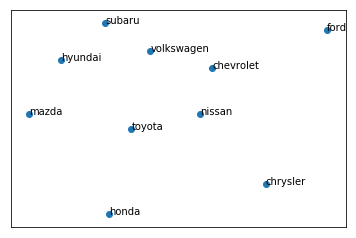

In [102]:
mds = MDS(n_components=2, random_state = 2, dissimilarity ='precomputed')
X_mds = mds.fit(dissimilarity).embedding_
plt.scatter(X_mds[:,0],X_mds[:,1], label = lift_df.columns.values)
# remove tickmarks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          
    which='both',      
    left=False,      
    right=False,     
    labelleft=False)

for i in range(len(lift_df.columns.values)):
    plt.annotate(s=lift_df.columns.values[i],xy= (X_mds[:,0][i],X_mds[:,1][i]))

### Potential Insights for a Brand Manager

-	Say we’re advising the brand managers for **Honda**:
  - Within the midsized sedans market, we have done a good job distancing ourselves from our competitors (especially the ones commonly associated with us, such as other Japanese car makers).
  - While this may raise concerns about consumers not switching from others to us, our brand is by far the most mentioned in the data we analyzed (in > 1500 of the almost 5000 comments analyzed, followed by Ford at about 1000 mentions). This signifies that we are maintaining a solid leadership in this market, most likely thanks to the Accord.
  - That said, we cannot become complacent. Toyota is relatively close to us compared to other brands, and it is the third most mentioned brand in the data we analyzed. We know that Toyota’s Camry is a fierce competitor in the midsized sedans market. We already offer Accord models with similar, if not lower, price points compared to Camry models. To compete with Toyota, we should focus on solidifying our leadership position in the midsized sedans market (to further reduce consumer inclination to switch while keeping Honda as the most discussed sedan) and/or to enhance our brand in reliability and fuel efficiency, Toyota’s two main selling points.
- Say we’re advising the brand managers for **Volkswagen**:
  - While we may have a preconceived notion that our cars are of higher quality than an average car, we’re facing competition internationally in the midsized sedans market. Consumers often discuss us with a plethora of other brands.
  - This can be concerning: our customers may be  more likely to switch to other brands than we estimated. However, it also indicates that if we understand the strengths of other brands, we may have a good chance in getting their customers to switch to VW as well.
  - Looking at each competitor directly, we appear to be the most similar to Subaru, potentially because both brands are considered to be safe and reliable. If we can further improve our safety reputation, we may just start convincing Subaru customers to switch over.
  - Many also compare us to Chevrolet. This is somewhat surprising as Chevrolet is more known for its SUVs. We should capitalize on that reputation and push our image as an experienced sedan maker.
  - Keep in mind, the above are just based on initial analyses and research. We likely have to do further investigation to determine why VW is so frequently discussed with each of the other brands, determine the most profitable competition we should pursue, and identify the best way to tackle that competitor.

### Top 5 Most Frequently Mentioned Attributes

In [103]:
from nltk import pos_tag
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [104]:
tagged_messages = [nltk.pos_tag(message) for message in messages]

In [106]:
def filter_nouns(messages):
    filtered_messages = []
    for message in messages:
        filtered_message=[]
        for word in message:
            if word[1] in ["NN","NNS"]:
                filtered_message.append(word[0])
        filtered_messages.append(filtered_message)
    return filtered_messages

In [107]:
filtered_messages = filter_nouns(tagged_messages)

In [108]:
def createFreqDictAll(messages):
    freqDict = {}
    for message in messages:
        for word in message:
            if word not in freqDict.keys():
                freqDict[word] = 1
            else:
                freqDict[word] +=1 
    return freqDict

In [109]:
noun_freq = createFreqDictAll(filtered_messages)

In [111]:
noun_freq = pd.Series(noun_freq).sort_values(ascending=False)

In [2]:
noun_freq.to_csv("noun_frequency.csv", sep="\t")
# upload_file("noun_frequency.csv")

In [3]:
# download_file("1r3EB2JViyxyjYFL1UA6zBQEGqRlLzAFV","noun_frequency_marked_categorized.csv")

In [113]:
# reviewed the exported csv and grouped the nouns into different categories of attributes as appropriate:
noun_freq_adjusted = pd.read_csv("noun_frequency_marked_categorized.csv")

In [114]:
marked_attributes = noun_freq_adjusted.dropna()

In [115]:
marked_attributes[:5]

Marked Attribute  Count     Category
13      x    engine  468.0  Performance
14      x     price  457.0        Value
16      x     drive  418.0   Experience
17      x      look  416.0   Aesthetics
19      x      sale  402.0        Value

In [117]:
marked_attributes[["Category", "Attribute"]][:10]

Category Attribute
13      Performance    engine
14            Value     price
16       Experience     drive
17       Aesthetics      look
19            Value      sale
23  Fuel Efficiency       mpg
24          Service    dealer
28          Service   problem
29          Comfort      seat
30      Performance     power

In [118]:
attribute_categories = marked_attributes["Category"].drop_duplicates().values

In [119]:
messages[:5]

0    [@, ahightower, said, :, honda, navi, manual, ...
1    [ahightower, :, by, chance, manual, sport, ?, ...
2    [hightower, ,, one, would, expect, ex, better,...
3    [best, mt, i, 've, ever, driven, ., smooth, sh...
4    [ahightower, :, thanks, report, ., but, darn, ...
Name: Message, dtype: object

In [122]:
def create_word_of_interest_list(message, wordsOfInterest):
    """
    args:
        message (str): message to check whether words exist
        wordsOfInterest (str): interested words to spot
    return:
        the words of interest that exist in the msg
    """
    words_of_interest_list = []
    for word in wordsOfInterest:
        if word in message:
            words_of_interest_list.append(word)
    return words_of_interest_list

In [123]:
def check_in_list_return_binary(wordList, word):
    if word in wordList:
        return 1
    else:
        return 0

In [124]:
def create_binary_df(messages, wordsToBinary):
    """ determine if each word in the interersted list is in each message"""
    binary_df = pd.DataFrame(messages)
    binary_df["WOI in Message"] = binary_df["Message"].apply(create_word_of_interest_list, args=(wordsToBinary,))
    for word in wordsToBinary:
        binary_df[word] = binary_df["WOI in Message"].apply(check_in_list_return_binary, args=(word,))
    return binary_df

In [125]:
jacob_test = create_binary_df(messages, ["sport", "best"])

In [126]:
jacob_test.columns.values[2:]

array(['sport', 'best'], dtype=object)

In [127]:
def calculate_lift_general(df, word1, word2):
    numerator = ((df[word1]*df[word2]).sum())/len(df)
    p_word1 = df[word1].sum()/len(df)
    p_word2 = df[word2].sum()/len(df)
    lift = numerator/(p_word1*p_word2)
    return lift

In [128]:
def create_lift_df_general(binaryDF1, binaryDF2):
    combinedDF = binaryDF1.merge(binaryDF2, left_index=True, right_index=True)
    liftDF = pd.DataFrame()
    for word1 in binaryDF1.columns.values[1:]:
        for word2 in binaryDF2.columns.values[2:]:
            liftDF.loc[word1, word2] = calculate_lift_general(combinedDF, word1, word2)
    return liftDF

In [148]:
marked_attributes[marked_attributes["Category"]=="Performance"]["Attribute"].drop_duplicates().values

array(['engine', 'power', 'wheel', 'speed', 'transmission', 'turbo',
       'cvt', 'hp', 'control', 'motor', 'performance', 'mph', 'v6',
       'driving', 'stick', 'awd', 'center', 'acceleration', 'torque',
       'suspension', 'shift', 'brake', 'trans', 'standard', 'cylinder',
       'winter', 'rpm', 'cyl', 'clutch', 'weight', 'lb', 'powertrain',
       'exhaust', 'horsepower'], dtype=object)

In [149]:
# check performance attribute
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Performance"]["Attribute"].drop_duplicates().values))

engine     power     wheel     speed  transmission     turbo  \
ford     1.480056  1.672880  1.571414  1.342912      1.371918  1.495672   
toyota   1.383064  1.252586  1.352415  1.211383      1.444808  1.063825   
hyundai  1.301238  1.557100  1.216949  1.080389      1.374602  1.549687   
mazda    1.630182  1.660940  1.569904  1.398686      1.285251  1.855777   

              cvt        hp   control     motor  ...  cylinder    winter  \
ford     0.820805  1.393694  0.975586  1.103765  ...  1.801082  1.425856   
toyota   1.438517  1.121576  1.378855  1.827450  ...  1.690991  1.503103   
hyundai  0.921101  1.396422  1.191913  1.748075  ...  0.842150  1.368493   
mazda    1.107293  2.313452  1.393046  2.206504  ...  1.439481  0.996564   

              rpm       cyl    clutch    weight        lb  powertrain  \
ford     0.750451  1.074798  1.330344  1.668765  1.707275    1.300781   
toyota   1.315215  1.966454  0.555123  1.526589  1.424817    1.628362   
hyundai  1.789568  0.811818  0.995268  1.350487  1.368493    2.736986   
mazda    1.660940  1.829849  1.439481  1.420541  0.839697    1.799352   

          exhaust  horsepower  
ford     0.696847    1.535645  
toyota   1.453895    1.243888  
hyundai  1.520548    1.773973  
mazda    1.256690    1.599424  

[4 rows x 34 columns]

not indicitive of performance: tire, weather

In [151]:
# Check Value attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Value"]["Attribute"].drop_duplicates().values))

price      sale      deal     money    market     lease  warranty  \
ford     1.110076  1.710916  1.170044  1.292443  1.205136  0.956457  1.058175   
toyota   1.469801  2.597480  1.361553  1.383064  1.975586  1.646322  1.260042   
hyundai  1.542175  2.042527  2.450342  1.637513  1.489243  2.347905  1.773973   
mazda    1.448931  2.506559  1.507565  1.476391  2.159222  0.987879  1.218608   

            value      term   package  ...   premium  incentive       tax  \
ford     1.110150  1.323469  1.380546  ...  1.659502   1.625977  0.975586   
toyota   1.768738  2.035452  1.324964  ...  1.321995   1.603690  1.119499   
hyundai  1.840387  1.697356  2.130202  ...  1.058113   2.349938  2.052740   
mazda    1.489119  1.673815  1.561701  ...  0.964601   0.799712  0.479827   

             cash  insurance  purchase    profit    rebate     worth   pricing  
ford     1.653535   1.177431  0.975586  1.535645  2.438965  0.883073  1.756055  
toyota   1.655961   0.421128  1.221271  2.487775  1.962758  0.947538  1.465526  
hyundai  0.463896   1.179735  1.710616  0.633562  2.321551  1.533656  2.326438  
mazda    0.731940   1.489119  0.839697  2.265850  1.927877  1.489119  2.303170  

[4 rows x 29 columns]

not indicative of value: cost, quote, life, fee

In [153]:
# Check Comfort attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Comfort"]["Attribute"].drop_duplicates().values))

seat      room  visibility     trunk     space    safety  \
ford     1.081124  0.929129    0.930903  1.104437  1.266995  1.540399   
toyota   1.627288  1.671979    1.351789  1.440179  1.189550  1.526589   
hyundai  1.588752  1.629159    1.096884  1.936547  1.066358  1.620584   
mazda    1.633185  1.713668    1.318609  1.561701  1.215147  1.515243   

             view     cabin  capacity  
ford     1.682045  2.090541  2.317017  
toyota   1.473948  2.507968  1.984566  
hyundai  1.415683  1.710616  0.855308  
mazda    1.240932  2.827552  1.259546

not indicative of comfort: box

In [155]:
# Check experiement attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Experience"]["Attribute"].drop_duplicates().values))

drive      ride     sound  experience      feel       fun  \
ford     1.276115  1.101468  1.179280    1.058775  1.369573  1.202777   
toyota   1.540768  1.997932  1.644019    1.562091  1.644019  1.547501   
hyundai  1.186310  1.765798  1.127879    1.538229  1.315859  1.359120   
mazda    1.615517  1.691556  1.423663    1.394846  1.688622  1.577514   

             love  
ford     1.494141  
toyota   1.210269  
hyundai  1.202055  
mazda    1.653458

all seem to be indicative

In [157]:
# Check technology attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Technology"]["Attribute"].drop_duplicates().values))

feature      base    system    camera    button     light     radio  \
ford     1.198813  1.311712  1.263712  0.959593  1.799625  1.021556  1.250751   
toyota   1.319594  1.462447  1.392123  1.251303  1.363555  1.214877  1.644019   
hyundai  1.565649  2.357488  0.957236  1.121716  0.597885  1.253855  1.754478   
mazda    1.463879  1.633025  1.193352  1.179903  1.257799  0.904386  1.476391   

         technology    cruise    screen  equipment    stereo   display  \
ford       1.279457  0.573874  1.540399   1.016235  0.909445  1.951172   
toyota     1.501563  0.897994  1.767630   0.763295  0.827981  1.465526   
hyundai    0.448686  1.408743  1.530552   2.138271  1.507662  1.368493   
mazda      0.943922  1.164286  0.947027   1.799352  1.463879  2.159222   

             tech    backup  engineering  navigation  computer  
ford     1.343198  0.920364     1.277553    1.134402  1.540399  
toyota   1.592963  0.921714     1.599284    1.562091  1.606936  
hyundai  1.784991  1.807444     0.651663    0.795636  1.260454  
mazda    2.294825  0.950601     0.514100    1.506434  0.947027

not indicative of tech: phone, stock

In [159]:
# check fuel attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Fuel Efficiency"]["Attribute"].drop_duplicates().values))

mpg      mile       gas      fuel   mileage   economy     range  \
ford     1.303414  1.052546  0.871800  1.757635  1.600962  1.552069  0.598237   
toyota   1.112494  1.105095  1.143318  0.889995  0.970754  1.054734  0.979321   
hyundai  1.579031  1.365318  1.077324  1.218901  0.842150  1.306289  1.936547   
mazda    1.252990  1.018658  1.286345  0.757622  0.848925  0.850603  1.018501   

             tank       epa    volume    gallon       doe    hybrid     liter  \
ford     1.170703  1.362951  1.022792  1.773793  0.935493  2.276367  1.764358   
toyota   1.038081  1.346991  2.265261  0.777173  1.338380  1.739387  0.909457   
hyundai  1.300068  1.911865  0.882899  1.741719  1.218521  0.580573  1.747013   
mazda    0.647767  1.622945  1.625221  0.916034  0.887351  0.872413  1.531363   

             pump  
ford     1.294145  
toyota   1.744673  
hyundai  1.256779  
mazda    0.734429

all seem to be differentiating

In [161]:
# check aesthetics attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Aesthetics"]["Attribute"].drop_duplicates().values))

look      show      size      area     class    design      side  \
ford     1.329118  1.020613  1.260821  1.378545  1.726969  1.356775  1.364659   
toyota   1.393567  1.089750  1.500715  1.858456  2.427372  2.426367  1.308505   
hyundai  1.514239  1.305332  1.739610  1.822178  2.337488  1.767259  1.466243   
mazda    1.363824  1.151585  1.433382  1.682003  2.279924  1.525278  1.028201   

            color      door     front  ...     floor     steel   plastic  \
ford     1.463379  1.463379  1.286698  ...  1.073145  2.048730  1.237684   
toyota   1.550075  1.017726  1.610732  ...  0.732763  0.732763  2.096212   
hyundai  1.368493  1.140411  1.885719  ...  0.821096  1.231644  2.042527   
mazda    1.827034  1.499460  1.445149  ...  1.439481  1.151585  1.503936   

         aluminum   sunroof      roof     paint  moonroof     board   leather  
ford     1.688514  1.045271  0.961845  1.773793  2.013114  1.509835  1.230879  
toyota   1.056869  0.785103  1.118065  0.971466  1.066189  1.308505  1.198444  
hyundai  0.789515  0.879746  1.156473  2.021638  1.303327  1.466243  1.215017  
mazda    0.553647  1.645121  1.115091  2.126506  1.370935  0.342734  1.883433  

[4 rows x 34 columns]

all seem to be differentiating

In [163]:
# check service attributes
create_lift_df_general(res[["honda", "ford", "toyota", "hyundai", "mazda"]], create_binary_df(messages, marked_attributes[marked_attributes["Category"]=="Service"]["Attribute"].drop_duplicates().values))

dealer   problem     issue   quality  reliability   service  \
ford     1.041769  1.116975  1.360192  1.616685     1.562462  0.955471   
toyota   1.304121  1.398267  1.555947  2.058715     2.146766  1.510851   
hyundai  1.547291  1.289160  1.217169  1.759491     2.245184  1.410818   
mazda    1.446715  1.001378  1.487925  2.097530     1.911811  1.038801   

            noise     start  dealership      help    repair      care  \
ford     1.231322  1.437706    1.865091  1.020962  0.804054  1.150081   
toyota   2.312116  1.189133    2.035452  1.420083  1.342056  1.886517   
hyundai  1.860088  0.864311    0.737913  1.166932  1.278263  1.335115   
mazda    2.515598  1.136433    2.610824  1.283258  1.265478  1.521403   

          trouble  condition    recall  
ford     1.951172   1.588163  1.078279  
toyota   2.442543   0.994058  2.121156  
hyundai  1.824658   2.068652  2.088753  
mazda    2.399135   1.841197  0.681860

not indicative of service: oil, maintenance

In [167]:
# Drop the non-indicative words from marked_attributes
attributes_to_drop = ["tire","weather","cost","quote","life","fee","box","phone","stock","oil","maintenance"]
marked_attributes = marked_attributes[~marked_attributes['Attribute'].isin(attributes_to_drop)]

### Choose top 5 most frequently mentioned attributes

In [168]:
marked_attributes[["Count", "Category"]].groupby("Category").sum().sort_values(by="Count", ascending=False).iloc[:5]

Count
Category               
Performance      3895.0
Value            3463.0
Aesthetics       3275.0
Fuel Efficiency  1997.0
Service          1953.0

In [169]:
top5_categories = marked_attributes[["Count", "Category"]].groupby("Category").sum().sort_values(by="Count", ascending=False).iloc[:5].index.values

In [170]:
top5_categories

array(['Performance', 'Value', 'Aesthetics', 'Fuel Efficiency', 'Service'],
      dtype=object)

### Calculate lift ratios between the top 5 attributes and top 5 brands

In [171]:
category_translation = {}
attributes = marked_attributes["Attribute"].values
categories = marked_attributes["Category"].values
for i in range(0,len(marked_attributes)):
    category_translation[attributes[i]] = categories[i]

In [172]:
category_translation

{'engine': 'Performance',
 'price': 'Value',
 'drive': 'Experience',
 'look': 'Aesthetics',
 'sale': 'Value',
 'mpg': 'Fuel Efficiency',
 'dealer': 'Service',
 'problem': 'Service',
 'seat': 'Comfort',
 'power': 'Performance',
 'mile': 'Fuel Efficiency',
 'show': 'Aesthetics',
 'deal': 'Value',
 'wheel': 'Performance',
 'size': 'Aesthetics',
 'gas': 'Fuel Efficiency',
 'money': 'Value',
 'speed': 'Performance',
 'feature': 'Technology',
 'transmission': 'Performance',
 'fuel': 'Fuel Efficiency',
 'base': 'Technology',
 'system': 'Technology',
 'turbo': 'Performance',
 'mileage': 'Fuel Efficiency',
 'area': 'Aesthetics',
 'issue': 'Service',
 'market': 'Value',
 'room': 'Comfort',
 'quality': 'Service',
 'class': 'Aesthetics',
 'lease': 'Value',
 'cvt': 'Performance',
 'hp': 'Performance',
 'warranty': 'Value',
 'ride': 'Experience',
 'value': 'Value',
 'control': 'Performance',
 'design': 'Aesthetics',
 'side': 'Aesthetics',
 'motor': 'Performance',
 'color': 'Aesthetics',
 'visibility

In [173]:
def get_message_attributes(message):
    category_list = []
    for word in message:
        if word in category_translation.keys() and category_translation[word] not in category_list:
            category_list.append(category_translation[word])
    return category_list

In [174]:
messages_categories = pd.DataFrame(messages.copy())

In [175]:
messages_categories["Categories"] = messages_categories["Message"].map(get_message_attributes)

In [176]:
def set_category_binaries(messageCategories, category):
    if category in messageCategories:
        return 1
    else:
        return 0

In [177]:
for category in marked_attributes["Category"].drop_duplicates().values:
      messages_categories[category] = messages_categories["Categories"].apply(set_category_binaries, args=(category,))

In [178]:
messages_categories

Message  \
0     [@, ahightower, said, :, honda, navi, manual, ...   
1     [ahightower, :, by, chance, manual, sport, ?, ...   
2     [hightower, ,, one, would, expect, ex, better,...   
3     [best, mt, i, 've, ever, driven, ., smooth, sh...   
4     [ahightower, :, thanks, report, ., but, darn, ...   
5     [@, dudleyr, said, :, what, major, tuneup, ?, ...   
6     [explorerx4, :, my, 2002, honda, i-4, timing, ...   
7     [you, never, leave, chevrolet, plug, place, 10...   
8     [@, akirby, said, :, you, never, leave, chevro...   
9     [we, 've, commented, ,, difference, year, make...   
10    [actually, ,, looking, today, 's, newspaper, l...   
11    [wow, ,, much, comment, ., i, agree, ahightowe...   
12    [@, explorerx4, said, :, ok, -, 100k, mile, 7,...   
13    [@, ahightower, said, :, -10-way, power, adjus...   
14    [i, looked, 2013, sport, m/t, ex, ., both, 8, ...   
15    [@, m6user, said, :, garythesnail, usually, ad...   
16    [only, player, really, satisfied, place, midsi...   
17    [auto, news, :, toyota, ready, remix, 'waku-do...   
18    [i, heard, mazda, hugely, disappointed, sale, ...   
19    [ab348, :, really, ?, i, n't, know, ..., .if, ...   
20    [the, 2014, mazda, 6, redesigned, ., review, e...   
21      [the, honda, still, best, buy, midsize, lot, .]   
22    [@, benjaminh, said, :, ab348, really, ?, i, n...   
23    [@, benjaminh, said, :, my, prediction, 2014, ...   
24    [@, ab348, said, :, i, heard, mazda, hugely, d...   
25    [the, mazda, 3, nice, car, much, small, conten...   
26    [@, cski, said, :, ..., .it, buyer, market, ,,...   
27    [a, toyota, per, unit, cost, 1k, vehicle, le, ...   
28    [mazda, ,, everything, i, 've, read, news, see...   
29    [the, toyota, nice, little, vehicle, ., i, thi...   
...                                                 ...   
4970  [oh, yeah, ., i, forgot, add, ,, larger, compa...   
4971       [so, called, midsize, sedan, gotten, big, .]   
4972  [yup, ., i, consider, big, one, like, hyundai,...   
4973  [@, stickguy, might, help, re-capture, youth, ...   
4974                   [i, need, quick, run, target, .]   
4975  [now, run, driving, quickly, store, ,, get, he...   
4976  [have, n't, driven, ford, trip, since, i, got,...   
4977  [berri, said, :, now, run, driving, quickly, s...   
4978  [andres3, said, :, i, think, 's, sale, pitch, ...   
4979                                       [eurocopter]   
4980  [hyundai, 6k, cash, hood, (, 16, 17, ), !, act...   
4981  [i, got, flyer, local, dealer, week, ., you, n...   
4982  [up, hyundai, running, national, ad, lease, $,...   
4983                              [how, much, front, ?]   
4984  [it, 's, funny, n't, mention, lease, car, enou...   
4985  [stickguy, said, :, i, got, flyer, local, deal...   
4986  [stickguy, said, :, i, got, flyer, local, deal...   
4987  [that, base, model, ., still, pretty, well, eq...   
4988     [here, 's, blurb, hyundai, canada, website, :]   
4989  [so, $, 200, month, 7, year, ., i, might, pref...   
4990  [i, know, ``, monthly, '', buyer, ., ignore, p...   
4991  [some, great, deal, class, ., even, $, 23k, st...   
4992  [stickguy, said, :, so, $, 200, month, 7, year...   
4993  [fwiw, ,, $, 1695, lease, ad, equates, another...   
4994  [it, 's, probably, wash, ., the, difference, ~...   
4995  [spent, time, driving, volkswagen, ., liking, ...   
4996  [is, volkswagen, 1.8t, engine, ?, i, wondering...   
4997  [when, i, ohio, last, week, ,, saw, ad, tv, 10...   
4998  [yes, ,, 1.8t, ., nice, car, not, really, much...   
4999  [stickguy, said, :, spent, time, driving, volk...   

                                             Categories  Performance  Value  \
0                                               [Value]            0      1   
1                                         [Performance]            1      0   
2          [Value, Performance, Technology, Aesthetics]            1      1   
3     [Performance, Technology, Fuel Efficiency, Com...            1     

In [179]:
brand_attribute_lifts = pd.DataFrame(columns=marked_attributes["Category"].drop_duplicates().values)

In [180]:
binary_combined = pd.concat([res, messages_categories], axis=1)

In [181]:
binary_combined.iloc[:2]

acura  audi  bmw  buick  cadillac  chevrolet  chrysler  dodge  ford  honda  \
0      0     0    0      0         0          0         0      0     0      1   
1      0     0    0      0         0          0         0      0     0      1   

   ...                                            Message     Categories  \
0  ...  [@, ahightower, said, :, honda, navi, manual, ...        [Value]   
1  ...  [ahightower, :, by, chance, manual, sport, ?, ...  [Performance]   

   Performance  Value  Experience  Aesthetics  Fuel Efficiency  Service  \
0            0      1           0           0                0        0   
1            1      0           0           0                0        0   

   Comfort  Technology  
0        0           0  
1        0           0  

[2 rows x 36 columns]

In [184]:
def calculate_lift_ba(brand, attribute):
    numerator = ((binary_combined[brand]*binary_combined[attribute]).sum())/len(binary_combined)
    p_brand = binary_combined[brand].sum()/len(binary_combined)
    p_attribute = binary_combined[attribute].sum()/len(binary_combined)
    lift = numerator/(p_brand*p_attribute)
    return lift

In [185]:
for brand in df["Brand"].values:
    row_lifts = []
    for attribute in marked_attributes["Category"].drop_duplicates().values:
        row_lifts.append(calculate_lift_ba(brand, attribute))
    brand_attribute_lifts.loc[brand] = row_lifts

In [186]:
brand_attribute_lifts.idxmax()

Performance         suzuki
Value               suzuki
Experience          suzuki
Aesthetics         mercury
Fuel Efficiency     saturn
Service             suzuki
Comfort            mercury
Technology         mercury
dtype: object

In [187]:
brand_attribute_lifts.idxmin()

Performance        mitsubishi
Value                cadillac
Experience         mitsubishi
Aesthetics         mitsubishi
Fuel Efficiency       lincoln
Service                 buick
Comfort            mitsubishi
Technology         mitsubishi
dtype: object

In [188]:
# lift ratio table of top 5 brands vs. top 5 attributes
brand_attribute_lifts.iloc[:5][list(top5_categories)]

Performance     Value  Aesthetics  Fuel Efficiency   Service
honda       1.244837  1.298956    1.210509         1.364143  1.283938
ford        1.217261  1.239859    1.210410         1.256977  1.161563
toyota      1.056656  1.450067    1.261357         1.202496  1.358734
hyundai     1.090557  1.520933    1.293630         1.307382  1.286579
mazda       1.274950  1.435837    1.234741         1.174979  1.362684

### Identify the most inspirational brands in the dataset

#### Descriptions of the below "inspirational" analysis

I measured the aspiration of each brand by following these steps: 
- Filtered for the verbs (unigrams) in our messages
- Reviewed the verbs to determine aspirational verbs: want, wanted, looking, hope, and hoping
- Looked for synonyms of the above verbs, verbs and otherwise, and added to our list of aspirational words as appropriate
- Calculated the lift ratio for each brand with each of the aspirational word; eliminated the ones that might be skewing the results (i.e., extremely low for almost all brands)
- Created a list of "aspirational bigarms" starting with the identified verbs
- Flag each message on whether it is aspirational by identifying whether it has any bigram in the final set of aspirational bigrams
- Determined the “aspiration” lift ratio for each brand based on whether it is mentioned in each message and whether each of those messages is flagged as aspirational

In [189]:
import nltk
from nltk import pos_tag
nltk.download("averaged_perceptron_tagger")
tagged_messages = [nltk.pos_tag(message) for message in messages]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Unigram analysis

In [190]:
def filter_verb(message):   
    tagged_message = nltk.pos_tag(message)
    filtered_message = []
    for word in tagged_message:
        #print(word)
        if word[1] in ["VB", "VBP", "VBD", "VBG"]:
            filtered_message.append(word[0])
    return filtered_message
filter_verb(["Hello","I", "run"])

['run']

In [192]:
asp_filtered_messages = messages.map(filter_verb)

In [193]:
verb_freq = pd.Series(createFreqDictAll(asp_filtered_messages)).sort_values(ascending = False)

In [194]:
pd.set_option('display.max_rows', 500)
verb_freq.iloc[:100]
# upon inspection of the verbs, I decided to focus my aspirational efforts on these words: want, wanted, looking, hope, hoping

said           1636
get             906
think           884
'm              676
go              505
know            500
going           496
've             459
make            453
got             445
see             434
looking         366
say             366
want            364
i               348
driving         332
take            297
buy             288
look            285
getting         281
need            270
're             245
put             218
bought          205
find            196
took            179
went            171
drove           167
seem            162
keep            162
give            149
midsize         144
handling        140
sell            135
made            134
do              126
feel            124
come            124
believe         123
looked          122
consider        121
including       119
love            118
steering        117
agree           116
like            109
thought         108
trying          105
found           103
replace         101


In [195]:
# find synonyms, verbs or otherwise
from nltk.corpus import wordnet as wn
print(wn.synsets("want"), "\n",
      wn.synsets("wanted"), "\n",
      wn.synsets("looking"), "\n",
      wn.synsets("hope"), "\n",
      wn.synsets("hoping"), "\n",)

[Synset('privation.n.01'), Synset('lack.n.01'), Synset('need.n.02'), Synset('wish.n.01'), Synset('desire.v.01'), Synset('want.v.02'), Synset('want.v.03'), Synset('want.v.04'), Synset('want.v.05')] 
 [Synset('desire.v.01'), Synset('want.v.02'), Synset('want.v.03'), Synset('want.v.04'), Synset('want.v.05'), Synset('wanted.a.01'), Synset('cherished.s.01')] 
 [Synset('look.n.02'), Synset('looking.n.02'), Synset('look.v.01'), Synset('look.v.02'), Synset('look.v.03'), Synset('search.v.02'), Synset('front.v.01'), Synset('attend.v.02'), Synset('look.v.07'), Synset('expect.v.03'), Synset('look.v.09'), Synset('count.v.08'), Synset('looking.s.01')] 
 [Synset('hope.n.01'), Synset('hope.n.02'), Synset('promise.n.02'), Synset('hope.n.04'), Synset('hope.n.05'), Synset('hope.n.06'), Synset('hope.v.01'), Synset('hope.v.02'), Synset('hope.v.03')] 
 [Synset('hope.v.01'), Synset('hope.v.02'), Synset('hope.v.03'), Synset('hop.v.01'), Synset('hop.v.02'), Synset('hop.v.03'), Synset('hop.v.04'), Synset('hop.v

In [196]:
aspirational_words = ['want',"wish","desire",
                      'wanted',
                      'looking',"search",
                      'hope',
                      'hoping']

In [197]:
res[df['Brand'][:10].values]

honda  ford  toyota  hyundai  mazda  nissan  chevrolet  subaru  \
0         1     0       0        0      0       0          0       0   
1         1     0       0        0      0       0          0       0   
2         1     0       0        0      0       0          0       0   
3         1     0       0        0      1       0          0       0   
4         0     0       0        0      0       0          0       0   
5         0     1       0        0      0       0          0       0   
6         1     0       0        0      0       0          0       0   
7         0     0       0        0      0       0          1       0   
8         0     1       0        0      0       0          1       0   
9         1     1       0        1      1       1          0       0   
10        1     0       1        0      0       1          0       0   
11        1     0       0        0      0       0          0       0   
12        0     0       0        0      0       0          0       0   
13        1     0       0        0      0       0          0       0   
14        1     0       0        0      0       0          0       0   
15        0     0       0        0      1       0          0       0   
16        1     1       1        1      1       1          1       0   
17        0     0       1        0      0       0          0       0   
18        0     0       0        0      1       0          0       0   
19        1     0       0        0      1       0          0       0   
20        0     0       0        0      1       0          0       0   
21        1     0       0        0      0       0          0       0   
22        1     0       0        0      1       0          0       0   
23        1     1       1        0      1       1          0       0   
24        0     0       0        0      1       0          0       0   
25        0     0       0        0      1       0          0       0   
26        1     0       1        1      0       0          0       0   
27        1     0       1        0      0       0          0       0   
28        0     0       0        0      1       0          0       0   
29        0     0       1        1      1       0          0       0   
30        1     0       1        1      0       0          0       0   
31        0     0       1        0      0       0          0       0   
32        0     0       1        0      0       0          0       0   
33        0     0       1        0      1       0          0       0   
34        0     0       0        0      0       0          0       0   
35        1     0       0        0      1       0          0       0   
36        0     0       1        0      0       0          0       0   
37        0     0       1        0      1       0          0       0   
38        0     0       0        0      1       0          0       0   
39        1     0       0        0      1       0          0       0   
40        0     1       0        0      0       0          0       0   
41        1     0       0        0      1       1          0       0   
42        1     0       0        0      0       0          0       0   
43        1     1       0        0      0       0          0       0   
44        1     1       0        0      0       0          0       0   
45        1     1       1        0      0       0          0       0   
46        0     0       0        0      1       0          0       0   
47        0     0       0        0      0       0          0       0   
48        1     1       0        0      0       0          0       0   
49        1     1       0        0      0       0          0       0   
50        0     0       0        0      0       0          0       0   
51        1     0       0        0      0       0          0       0   
52        0     1       1        0      0       0          0       0   
53        0     1       0        0      0       0          0       0   
54        1     1       1        0      1     

In [198]:
create_lift_df_general(res[df['Brand'][:10].values], create_binary_df(messages, aspirational_words))

want      wish    desire    wanted   looking    search  \
ford        1.247842  1.291217  0.443448  1.446844  1.466044  1.045271   
toyota      1.549181  1.257191  1.110247  1.345468  1.685088  0.436168   
hyundai     1.113890  1.408743  0.622042  1.391688  1.645183  0.000000   
mazda       1.552083  2.116884  0.654310  1.585869  1.828849  0.000000   
nissan      1.233024  1.106680  0.855162  1.195777  1.567797  0.671913   
chevrolet   1.708625  1.815763  0.000000  1.141497  1.656106  2.405297   
subaru      1.652460  0.897994  1.110247  1.241971  2.235661  1.744673   
volkswagen  1.223606  0.740110  5.719029  2.132519  1.650081  0.000000   
chrysler    1.324763  2.106262  1.627566  2.124112  1.712057  2.557604   

                hope    hoping  
ford        1.445312  1.254325  
toyota      1.356968  1.046804  
hyundai     1.351598  0.781996  
mazda       1.243996  2.262042  
nissan      0.929065  1.343826  
chevrolet   1.524345  1.282825  
subaru      0.603097  1.744673  
volkswagen  0.621327  1.078445  
chrysler    2.210275  1.023041

In [199]:
## may not be indicative: search
# update aspirational words
aspirational_words = ["want","wish","desire","wanted","looking","hope","hoping"]

In [200]:
def aspirational_determiner(message):
    aspirational = False
    for word in aspirational_words:
        if word in message:
            aspirational = True
    return aspirational

In [201]:
df_asp0 = pd.DataFrame(messages)
df_asp0['AspirationalFlag'] = df_asp0['Message'].map(aspirational_determiner)

In [202]:
df_asp = pd.concat([df_asp0, res], axis = 1)
print(df_asp.shape)
df_asp[:2]

(4995, 28)


Message  AspirationalFlag  acura  \
0  [@, ahightower, said, :, honda, navi, manual, ...              True      0   
1  [ahightower, :, by, chance, manual, sport, ?, ...             False      0   

   audi  bmw  buick  cadillac  chevrolet  chrysler  dodge  ...  mercury  \
0     0    0      0         0          0         0      0  ...        0   
1     0    0      0         0          0         0      0  ...        0   

   mitsubishi  nissan  pontiac  saturn  subaru  suzuki  toyota  volkswagen  \
0           0       0        0       0       0       0       0           0   
1           0       0        0       0       0       0       0           0   

   volvo  
0      0  
1      0  

[2 rows x 28 columns]

In [203]:
def calculate_lift_aspiration(df, brand, aspiration):
    """
    args: 
    df (pandas DataFrame): df containing all the data needed
    brand (str): name of brand
    aspiration (string): the column with the boolean value flagging whether an aspirational word occurs in a message

    returns:
    the lift value of the brand and aspirational verbs
    """
    numerator = ((df[brand]*df[aspiration]).sum())/len(df)
    p_brand = df[brand].sum()/len(df)
    p_aspiration = df[aspiration].sum()/len(df)
    lift = numerator/(p_brand*p_aspiration)
    return lift

In [204]:
calculate_lift_aspiration(df_asp,"honda","AspirationalFlag")

1.3221160130291798

In [205]:
brand_lifts = {}
for brand in df["Brand"].values:
    brand_lifts[brand] = [calculate_lift_aspiration(df_asp, brand, "AspirationalFlag")]

In [206]:
brand_lifts = pd.DataFrame(brand_lifts).T

In [311]:
# brand_lifts.columns = ['aspiration_lift_ratio']
# top_brand_lifts = brand_lifts[:10]
# top_brand_lifts.sort_values("aspiration_lift_ratio",ascending = False)

### bigram analysis

In [215]:
df_orig = pd.read_csv("midsize_sedans_5000.csv", sep = "\t", index_col = 0)
df_orig.dropna(how = 'any', inplace =True)
df_orig[:2]

Date     Userid  \
0  January 16, 2014 3:42PM  benjaminh   
1  January 16, 2014 3:52PM  benjaminh   

                                             Message  
0  @ahightower said:\nEX-L Navi manual - you real...  
1  ahightower: By any chance do you have the manu...

In [216]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [226]:
words = word_tokenize("this camera produces awesome pictures")
list(dict(Counter(ngrams(words, 2))).keys())

[('this', 'camera'),
 ('camera', 'produces'),
 ('produces', 'awesome'),
 ('awesome', 'pictures')]

In [228]:
def preparebigrams(message):
    """
    preparebigarms tokenizes, finds bigrams, and remove duplicate bigrams from a given string
    args:
        description (string): one string object that user would like to process
    returns:
        a list of bigrams
    """
    word_tokens = [word.lower() for word in word_tokenize(message)] # tokenize words
    bigrams = list(dict(Counter(ngrams(word_tokens, 2))).keys()) # find bigrams
    
    # remove duplicates
    removed_duplicates = []
    for bigram in bigrams:
        if bigram not in removed_duplicates:
            removed_duplicates.append(bigram)
    return removed_duplicates

preparebigrams("I love Honda Civic.")

[('i', 'love'), ('love', 'honda'), ('honda', 'civic'), ('civic', '.')]

In [229]:
df_orig['unigrams'] = df_orig['Message'].map(tokenizemessage)
df_orig['bigrams'] = df_orig['Message'].map(preparebigrams)

In [274]:
def create_bi_of_interest_list(message, bigramsOfInterest):
    """
    args:
        message (str): message (converted to bigrams) to check whether words exist
        wordsOfInterest (str): interested bigrams to spot
    return:
        the words of interest that exist in the msg
    """
    bigrams_of_interest_list = []
    for bigram in bigramsOfInterest:
        if bigram in message:
            bigrams_of_interest_list.append(bigram)
    return bigrams_of_interest_list

In [291]:
def check_in_list(message, bigram):
    if bigram in message:
        return 1
    else:
        return 0

In [276]:
def create_binary_bi_df(messages, bigramsToBinary):
    """ determine if each bigram in the interersted list is in each message"""
    bi_binary_df = pd.DataFrame(messages)
    bi_binary_df["BOI in Message"] = bi_binary_df["bigrams"].apply(create_bi_of_interest_list, args=(bigramsToBinary,))
    for bigram in bigramsToBinary:
        bi_binary_df[bigram] = bi_binary_df["BOI in Message"].apply(check_in_list, args=(bigram,))
    return bi_binary_df

In [277]:
# prepare aspirational_bigrams based on the unigrams selected in the previous step
aspirational_bigrams = [('want', 'to'),("wish", "for"),("desire", "for"),
                      ('looking', 'for'),("search", "for"),
                      ('hope', 'for'),
                      ('hoping', 'for')]

In [278]:
bi_binary_df = pd.DataFrame(df_orig['bigrams'])
bi_binary_df["BOI in Message"] = bi_binary_df["bigrams"].apply(create_bi_of_interest_list, args=(aspirational_bigrams,))
for bigram in aspirational_bigrams:
    bi_binary_df[bigram] = 0
for bigram in aspirational_bigrams:
    bi_binary_df[bigram] = bi_binary_df["BOI in Message"].apply(check_in_list, args=(bigram,))

In [300]:
bi_binary_df[:5]

bigrams BOI in Message  \
0  [(@, ahightower), (ahightower, said), (said, :...             []   
1  [(ahightower, :), (:, by), (by, any), (any, ch...             []   
2  [(a, hightower), (hightower, ,), (,, one), (on...             []   
3  [(best, mt), (mt, i), (i, 've), ('ve, ever), (...             []   
4  [(ahightower, :), (:, thanks), (thanks, for), ...             []   

   (want, to)  (wish, for)  (desire, for)  (looking, for)  (search, for)  \
0           0            0              0               0              0   
1           0            0              0               0              0   
2           0            0              0               0              0   
3           0            0              0               0              0   
4           0            0              0               0              0   

   (hope, for)  (hoping, for)  
0            0              0  
1            0              0  
2            0              0  
3            0              0  
4            0              0

In [301]:
def aspirational_determiner(message):
    aspirational = False
    for bigram in aspirational_bigrams:
        if bigram in message:
            aspirational = True
    return aspirational

bi_binary_df['AspirationalFlag'] = bi_binary_df['bigrams'].map(aspirational_determiner)

In [304]:
df_bi_asp = pd.concat([bi_binary_df.iloc[:,2:], res], axis = 1)
print(df_bi_asp.shape)
df_bi_asp[:2]

(4995, 34)


(want, to)  (wish, for)  (desire, for)  (looking, for)  (search, for)  \
0           0            0              0               0              0   
1           0            0              0               0              0   

   (hope, for)  (hoping, for)  AspirationalFlag  acura  audi  ...  mercury  \
0            0              0             False      0     0  ...        0   
1            0              0             False      0     0  ...        0   

   mitsubishi  nissan  pontiac  saturn  subaru  suzuki  toyota  volkswagen  \
0           0       0        0       0       0       0       0           0   
1           0       0        0       0       0       0       0           0   

   volvo  
0      0  
1      0  

[2 rows x 34 columns]

In [305]:
calculate_lift_aspiration(df_bi_asp,"honda","AspirationalFlag")

1.140343040914776

In [306]:
brand_bi_lifts = {}
for brand in df["Brand"].values:
    brand_bi_lifts[brand] = [calculate_lift_aspiration(df_bi_asp, brand, "AspirationalFlag")]

In [308]:
brand_bi_lifts = pd.DataFrame(brand_bi_lifts).T

In [309]:
brand_bi_lifts.columns = ['aspiration_lift_ratio']

In [310]:
top_brand_lifts = brand_bi_lifts[:10]
top_brand_lifts.sort_values("aspiration_lift_ratio",ascending = False)

aspiration_lift_ratio
subaru                   2.433184
chrysler                 1.920653
toyota                   1.661116
mazda                    1.461542
chevrolet                1.419217
hyundai                  1.415683
nissan                   1.153322
honda                    1.140343
volkswagen               1.060540
ford                     1.046606

### Business implications for the most aspired brand
The most aspired brand in the midsized sedans data in terms of people actually wanting to buy or own is **Subaru.** We often hear that Subaru has one of the highest brand loyalty in the auto industry. This list seems to confirm that reputation.

Regardless of the potential reason for its desirability, some implications for such trait are that Subaru may be able to 
- Build in some price premium; though we are in the midsized sedans market - this premium could not be too drastic
- Focus more of its sales and marketing efforts on retaining existing customers, and rely more on word of mouth for customer acquisition (an overall less costly marketing strategy)

However, it also means that Subaru is likely held to a higher standard than other brands. As such, the company must strive for continuous improvement to maintain such reputation